# Project Notebook

This project notebook replicates the work presented in the final report (ADD LINK).

#### Imports

In [1]:
# Basics
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical libraries
from scipy.stats import norm, chi2_contingency

# Custom utils functions
import sys; sys.path.append("./libraries/")
from utils import *

#### Settings

In [2]:
# Relative Paths
RAW_DATA = "../data/raw/"
PROC_DATA = "../data/processed/"

# Flags
process = False

# Replace files
write_2_disk = False

# Seed for reproducibility
seed = 7

# Set the style for plots
sns.set_style("whitegrid")

# Data

## Load and match datasets
We have two different dataset sources with different identifiers. To match players from Transfermarkt with their attributes from soFIFA, we use a custom function that looks at their names, date of birth and nationality to ensure they are the same player.

In [3]:
# If process, load raw data and apply matching between datasets
# NOTE: It may take several minutes
if process:
    # Raw player's datasets
    transfermarkt = pd.read_csv('https://query.data.world/s/gksm6hx4xzgjaed7tia2uzpafwvyjo?dws=00000')
    fifa22 = pd.read_csv(RAW_DATA + "FIFA22_player_ratings.csv") # FIFA player attributes from 2022
    fifas21 = pd.read_csv(RAW_DATA + "FIFA21_player_ratings.csv") # FIFA player attributes from 2022
    # This appends players from 2021 not present in 2022
    extended = set(fifas21.sofifa_id).difference(set(fifa22.sofifa_id))
    FIFA = pd.concat([fifa22, fifas21[fifas21.sofifa_id.isin(extended)]]).reset_index()

    # Remove uninformative columns
    transfermarkt.drop(["player_code", "agent_name", "image_url", "url"], axis=1, inplace=True)
    FIFA.drop(["player_url", "club_team_id", "club_position", "club_jersey_number", "club_loaned_from", "club_joined", 
                "nationality_id", "nation_team_id", "nation_jersey_number", "real_face", "player_tags", "player_face_url", 
                "club_logo_url", "club_flag_url", "nation_logo_url", "nation_flag_url"], axis=1, inplace=True)
    
    # Find matches using custom function
    longname_matches = match_players(transfermarkt, FIFA)
    # Append the extracted FIFA long names
    transfermarkt["FIFA_long_name"] = longname_matches

    ## Merge players with FIFA attributes
    # Create a unique identifier with long name and year of birth
    transfermarkt["fifa_id"] = transfermarkt["FIFA_long_name"] + "-" + pd.to_datetime(transfermarkt["date_of_birth"]).dt.year.astype(str)
    FIFA["fifa_id"] = FIFA.long_name + "-" + pd.to_datetime(FIFA["dob"]).dt.year.astype(str)
    # Join
    players = transfermarkt.merge(FIFA, on="fifa_id", how="inner")
    # Drop temp id cols
    players.drop(["name", "fifa_id", "sofifa_id"], axis=1, inplace=True)
    # Save dataset
    players.to_csv(PROC_DATA + "players_wFIFAattributes.csv", index=False)

# Else load processed data
else:
    players = pd.read_csv(PROC_DATA + "players_wFIFAattributes.csv")

# Get valuation data
#valuations = pd.read_csv('https://query.data.world/s/y4qg2twfvou4w2ghz6o3evju32g7yn?dws=00000') 
# ... (we can get some more datasets if needed)

# Glance at data
print(players.info())
players.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11159 entries, 0 to 11158
Columns: 112 entries, player_id to gk
dtypes: float64(15), int64(44), object(53)
memory usage: 9.5+ MB
None


,player_id,first_name,last_name,FIFA_long_name,last_season,country_of_birth,city_of_birth,country_of_citizenship,date_of_birth,sub_position,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
0,3875,Jermain,Defoe,Jermain Colin Defoe,2021,England,London,England,1982-10-07,Centre-Forward,...,43+2,43+2,43+2,43+2,40+2,38+2,38+2,38+2,40+2,18+2
1,4742,Christophe,Lepoint,Christophe Lepoint,2022,Belgium,Brussel,Belgium,1984-10-24,Central Midfield,...,68-1,68-1,68-1,62+2,62+2,67,67,67,62+2,16+2
2,6838,Henok,Goitom,Henok Goitom,2015,Sweden,Solna,Eritrea,1984-09-22,Centre-Forward,...,55+2,55+2,55+2,50+2,48+2,50+2,50+2,50+2,48+2,17+2
3,10003,Wes,Morgan,Wes Morgan,2020,England,Nottingham,Jamaica,1984-01-21,Centre-Back,...,64+2,64+2,64+2,54+2,57+2,73,73,73,57+2,16+2
4,10471,NaN,Luiz Gustavo,Luiz Gustavo Dias,2021,Brazil,Pindamonhangaba,Brazil,1987-07-23,Defensive Midfield,...,75+2,75+2,75+2,71+3,71+3,75+2,75+2,75+2,71+3,17+3


# II. Methods

## A. Histograms, Kernel Density Estimation and Chi-Square Goodnes-of-Fit Test

### Players' age distribution: Histogram and KDE vs. Normal Distribution plot
We can also plot the histogram of all players' age in the Transfermarkt dataset, to get a sense of the age distribution across players.

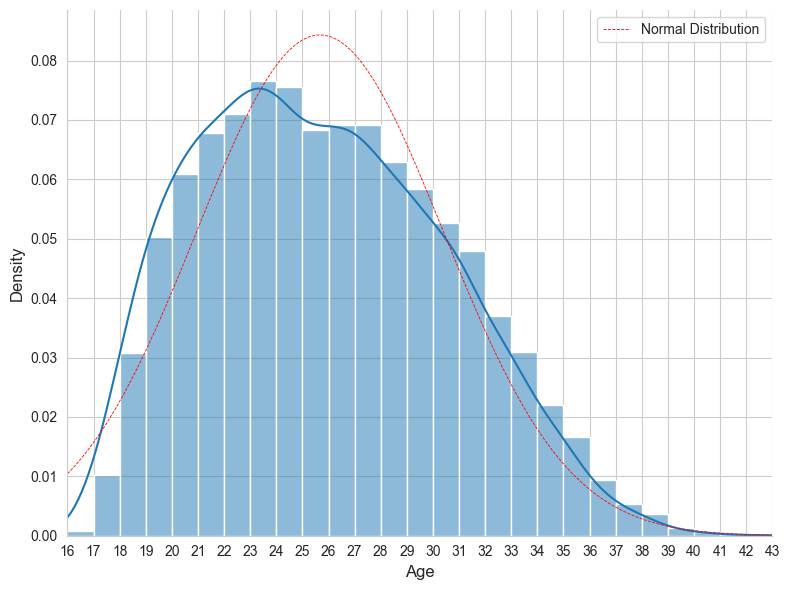

In [4]:
fig, ax = plt.subplots(figsize=(8,6))
plt.rcParams['axes.linewidth'] = 12

# Plot the histogram of ages
sns.histplot(data=players, x="age", kde=True, stat="density", bins=np.arange(players.age.min(), players.age.max() + 1), ax=ax)

# Fit a normal distribution to the data
mu, std = np.mean(players.age), np.std(players.age)
xmin, xmax = plt.xlim(players.age.min(), players.age.max())
plt.xticks(players.age.unique())
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, '--r', linewidth=0.6, label='Normal Distribution')

# Add labels
plt.xlabel('Age', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.tight_layout()

sns.despine(ax=ax, top=True, right=True)
# Show the plot
plt.show()

### Chi-Square Goodnes-of-Fit Test

The data appears roughly normally distributed, with a slight right tail. To test for a normal distribution fit, we use a Chi-square goodness of fit test, with an alpha level of 0.05. The chi-square test (Snedecor and Cochran, 1989) is used to test if a sample of data came from a population with a specific distribution. <br>
$H_0$:	The data follow a specified distribution (i.e., Normal). <br>
$H_a$:	The data do not follow the specified distribution.


In [5]:
# Select an alpha level
alpha = 0.05

# Total observations
N = players.shape[0]

# Parameters for the normal distribution (mean and standard deviation)
mean_age = np.mean(players.age)
std_age = np.std(players.age)

# Range of ages
ages = pd.Series(np.arange(players.age.min(), players.age.max()+1))

# Calculate the probability function for each age
expected_frequencies = N * norm.pdf(ages, loc=players.age.mean(), scale=players.age.std())

# Get the observed frequencies
observed_frequencies = players.groupby("age").size()

# Perform the chi-squared test
chi2_stat, p_value, dof, expected = chi2_contingency([observed_frequencies, expected_frequencies])

print(f"Chi-squared Statistic: {chi2_stat}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}")

if p_value < alpha:
    print("We reject the null hypothesis, and thus conclude the distribution is not normal.")
else:
    print("We cannot reject the null hypothesis, and thus it can be possible that the distribution is normal.")

Chi-squared Statistic: 330.2726147151785
P-value: 6.398325123547772e-54
Degrees of Freedom: 27
We reject the null hypothesis, and thus conclude the distribution is not normal.


## B. Survival Analysis
The first step is to recognize retired players. We apply the assumption that a player is retired if he hasn't played for over a year, has no current club, no market value and no contract.

In [6]:
# Detect retired:
## Conditions:
### Last season < 2021
### No current club (NAN)
### No Market value in EUR (NAN)
### No Contract Expiration date (NAN)

# Use custom function generate boolean flag for "Retired" players
players = detect_retired(players)

# A glance to the retire players
players[players.retired].head()

,player_id,first_name,last_name,FIFA_long_name,last_season,country_of_birth,city_of_birth,country_of_citizenship,date_of_birth,sub_position,...,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,retired
13,26105,Valter,Birsa,Valter Birsa,2019,Jugoslawien (SFR),Sempeter pri Gorici,Slovenia,1986-08-07,Attacking Midfield,...,64+2,64+2,63+2,60+2,59+2,59+2,59+2,60+2,11+2,True
32,42086,Timo,Perthel,Timo Perthel,2013,Germany,Kaiserslautern,Germany,1989-02-11,Left-Back,...,64+2,64+2,65+1,64+2,64+2,64+2,64+2,64+2,15+2,True
57,56820,Jérémy,Sorbon,Jérémy Sorbon,2018,France,Caen,France,1983-08-05,Centre-Back,...,64+2,64+2,59+2,60+2,69,69,69,60+2,17+2,True
73,62240,Maynor,Figueroa,Maynor Alexis Figueroa Róchez,2014,Honduras,Jutiapa,Honduras,1983-05-02,Left-Back,...,66+2,66+2,63+2,63+2,68,68,68,63+2,17+2,True
119,101922,Fabio,Pisacane,Fabio Pisacane,2020,Italy,Napoli,Italy,1986-01-28,Centre-Back,...,65+2,65+2,66+2,67+2,70,70,70,67+2,19+2,True


Now are all players in the dataset contain a "retired" flag.

### 1. Hazard rate, Activity Rate and Kapler-Meier Estimate

#### FOOTBALL PLAYERS PROFESSIONAL LIFE TABLE
Similar to the life tables in traditional Survival Analysis, the "professional life" table will compute the probability of retiring ('h') at a given age (based on their frequency), and a "Activity" ('A') probability at a given age, computed as the probability of NOT being retired at that age.

In [7]:
if process:
    professional_life_table = get_retire_table(players, ci=(0.025, 0.975), bootstrap_settings={"simulations": 10000})
    professional_life_table.to_csv(PROC_DATA + "professional_life_table.csv", encoding="utf-8", index=False)
else:
    professional_life_table = pd.read_csv(PROC_DATA + "professional_life_table.csv")

In [8]:
professional_life_table

,age,n,retired,h,A,0.025,0.975,e
0,16,9,0,0.000000,1.000000,1.000000,1.000000,21.014007
1,17,115,0,0.000000,1.000000,1.000000,1.000000,20.014007
2,18,344,2,0.005814,0.994186,0.984985,1.000000,19.014007
3,19,562,4,0.007117,0.987110,0.975403,0.996441,18.019821
4,20,680,7,0.010294,0.976949,0.962904,0.988789,17.032711
5,21,757,3,0.003963,0.973077,0.958769,0.985585,16.055763
6,22,793,4,0.005044,0.968169,0.952904,0.981502,15.082686
7,23,855,4,0.004678,0.963639,0.947846,0.977780,14.114517
8,24,843,1,0.001186,0.962496,0.946457,0.976769,13.150878
9,25,763,4,0.005242,0.957450,0.940889,0.972428,12.188382


In [9]:
# TEMP CODE TO WRITE TABLE AS LATEX
"""
dtypes= {k: int for k in professional_life_table.columns[:3]}
dtypes.update({k: float for k in professional_life_table.columns[3:]})
write_latex_table(professional_life_table, dtypes=dtypes)
"""

'\ndtypes= {k: int for k in professional_life_table.columns[:3]}\ndtypes.update({k: float for k in professional_life_table.columns[3:]})\nwrite_latex_table(professional_life_table, dtypes=dtypes)\n'

Let's plot the survival curve with the confidence intervals.

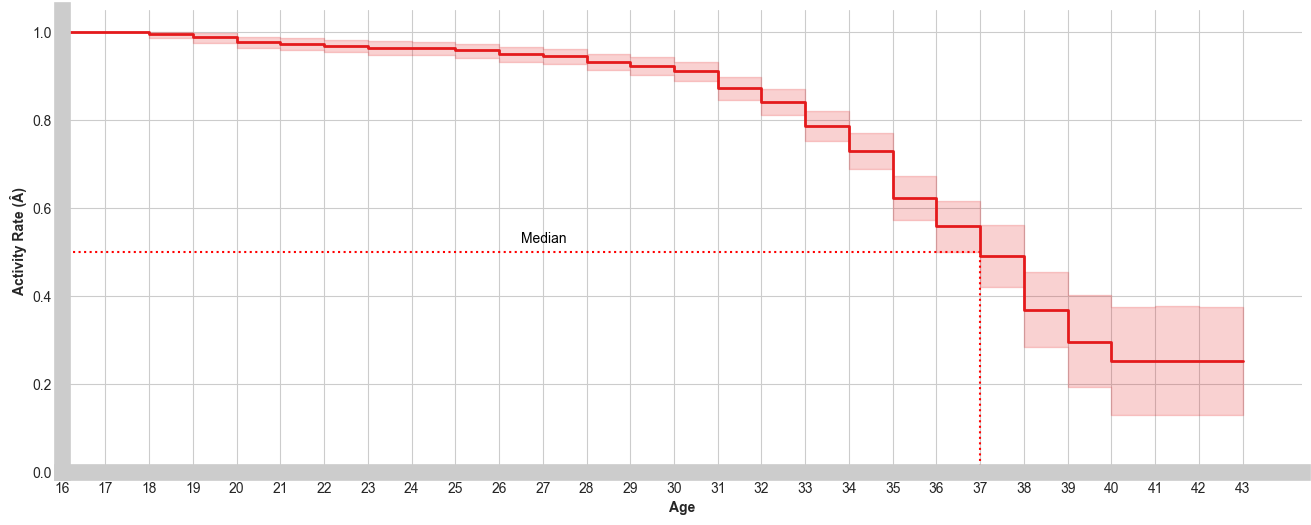

In [10]:
km_curves(professional_life_table, labels=None, ci=True)

### 3. KM Curves across different groups

We will test three different grouppings:
* Body Type (3 groups: Lean, Normal and Stocky)
* Work Rate (3 groups: Low, Medium, High)
* Position (2 groups: Goalkeepers, Field players)

This amounts to 7 comparisons, and thus we will do a bonferroni correction on our selected alpha of 0.05. 

In [11]:
n_tests = 7

#### Body Type

Let's see if there are differences between three groups of players: Lean, Normal and Stocky.

In [12]:
# Filter the players by group and calculate their life tables
body_type = {
    "Lean": {
        "sample": players[players.body_type.str.contains("Lean")],
        "table": get_retire_table(players[players.body_type.str.contains("Lean")], age_range=range(players.age.min(), players.age.max()+1))
    },
    "Normal": {
        "sample": players[players.body_type.str.contains("Normal")],
        "table": get_retire_table(players[players.body_type.str.contains("Normal")], age_range=range(players.age.min(), players.age.max()+1)) 
    },
    "Stocky": {
        "sample": players[players.body_type.str.contains("Stocky")],
        "table": get_retire_table(players[players.body_type.str.contains("Stocky")], age_range=range(players.age.min(), players.age.max()+1))    
    }
}
    

print("## SAMPLE SIZES PER GROUP ##")
for group in body_type:
    print(f"{group}: {len(body_type[group]['sample'])}")

## SAMPLE SIZES PER GROUP ##
Lean: 3632
Normal: 6747
Stocky: 645


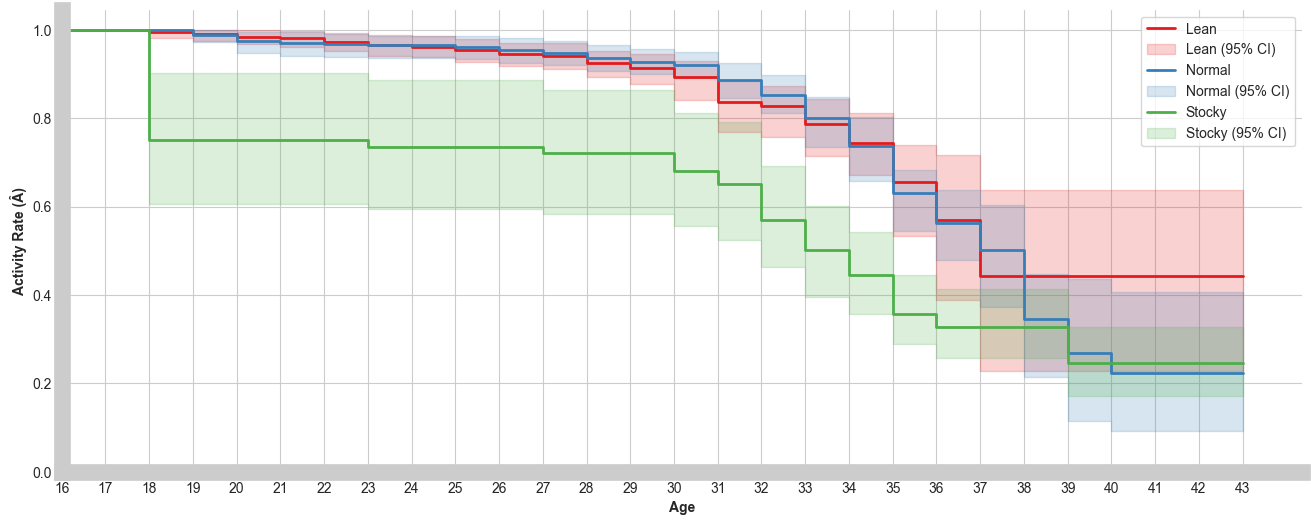

In [13]:
km_curves([body_type[k]["table"] for k in body_type], labels=[k for k in body_type], ci=True)

In [14]:
pairwise_log_rank_test([body_type[k]["table"] for k in body_type], labels=[k for k in body_type], n_tests=n_tests)

### 3 Comparisons | Corrected alpha: 0.0071 ###
Lean vs Normal -> Stat: 0.013865495515237879 - P-Value: 0.9062642911199789 - Not Rejected
Lean vs Stocky -> Stat: 2.3148124148433 - P-Value: 0.12814675905495898 - Not Rejected
Normal vs Stocky -> Stat: 3.225555689298307 - P-Value: 0.07249718741037403 - Not Rejected


#### Work Rate

In [15]:
# Filter the players by group and calculate their life tables
work_rate = {
    "Low": {
        "sample": players[players.work_rate.isin(["Low/Low", "Low/Medium", "Medium/Low"])],
        "table": get_retire_table(players[players.work_rate.isin(["Low/Low", "Low/Medium", "Medium/Low"])], age_range=range(players.age.min(), players.age.max()+1))
    },
    "Medium": {
        "sample": players[players.work_rate.isin(["Medium/Medium", "Low/High", "High/Low"])],
        "table": get_retire_table(players[players.work_rate.isin(["Medium/Medium", "Low/High", "High/Low"])], age_range=range(players.age.min(), players.age.max()+1)) 
    },
    "High": {
        "sample": players[players.work_rate.isin(["High/High", "High/Medium", "Medium/High"])],
        "table": get_retire_table(players[players.work_rate.isin(["High/High", "High/Medium", "Medium/High"])], age_range=range(players.age.min(), players.age.max()+1))    
    }
}
    

print("## SAMPLE SIZES PER GROUP ##")
for group in work_rate:
    print(f"{group}: {len(work_rate[group]['sample'])}")

## SAMPLE SIZES PER GROUP ##
Low: 913
Medium: 6129
High: 4117


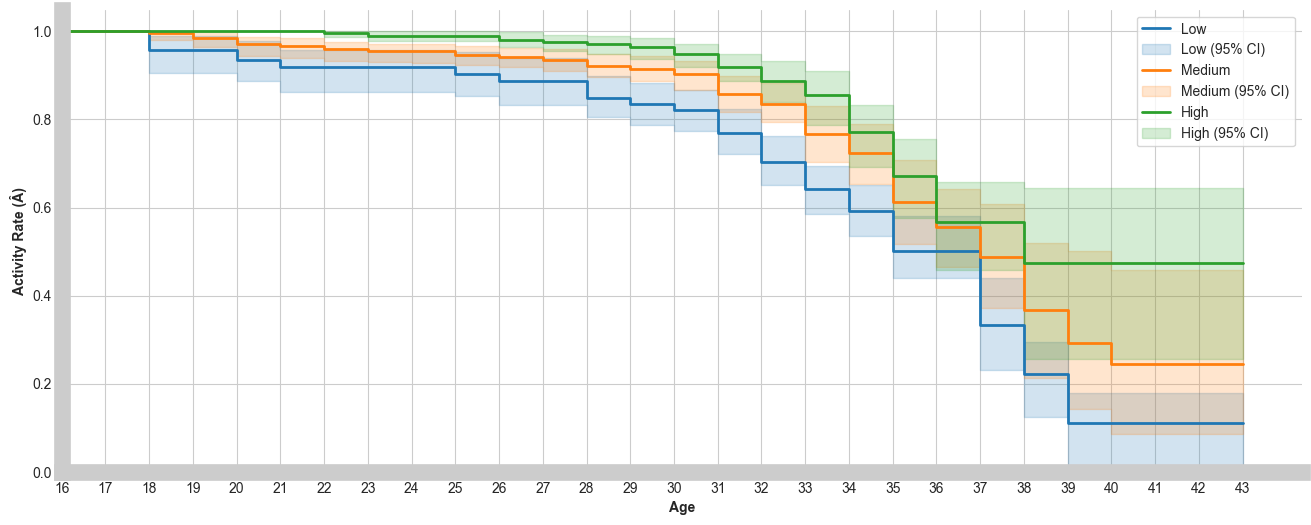

In [16]:
km_curves([work_rate[k]["table"] for k in work_rate], labels=[k for k in work_rate], ci=True, color_palette="tab10")

In [17]:
pairwise_log_rank_test([work_rate[k]["table"] for k in work_rate], labels=[k for k in work_rate], n_tests=n_tests)

### 3 Comparisons | Corrected alpha: 0.0071 ###
Low vs Medium -> Stat: 3.7995808106507787 - P-Value: 0.051265415806807435 - Not Rejected
Low vs High -> Stat: 8.316881228783883 - P-Value: 0.003927830235524454 - Rejected
Medium vs High -> Stat: 3.0578388949227984 - P-Value: 0.08034846801188134 - Not Rejected


#### Goalkeepers vs Field Players

In [18]:
# Filter the players by group and calculate their life tables
position = {
    "Goalkeeper": {
        "sample": players[players.position == "Goalkeeper"],
        "table": get_retire_table(players[players.position == "Goalkeeper"], age_range=range(players.age.min(), players.age.max()+1))
    },
    "FieldPlayer": {
        "sample": players[~(players.position == "Goalkeeper")],
        "table": get_retire_table(players[~(players.position == "Goalkeeper")], age_range=range(players.age.min(), players.age.max()+1)) 
    }
}
    

print("## SAMPLE SIZES PER GROUP ##")
for group in position:
    print(f"{group}: {len(position[group]['sample'])}")

## SAMPLE SIZES PER GROUP ##
Goalkeeper: 1167
FieldPlayer: 9992


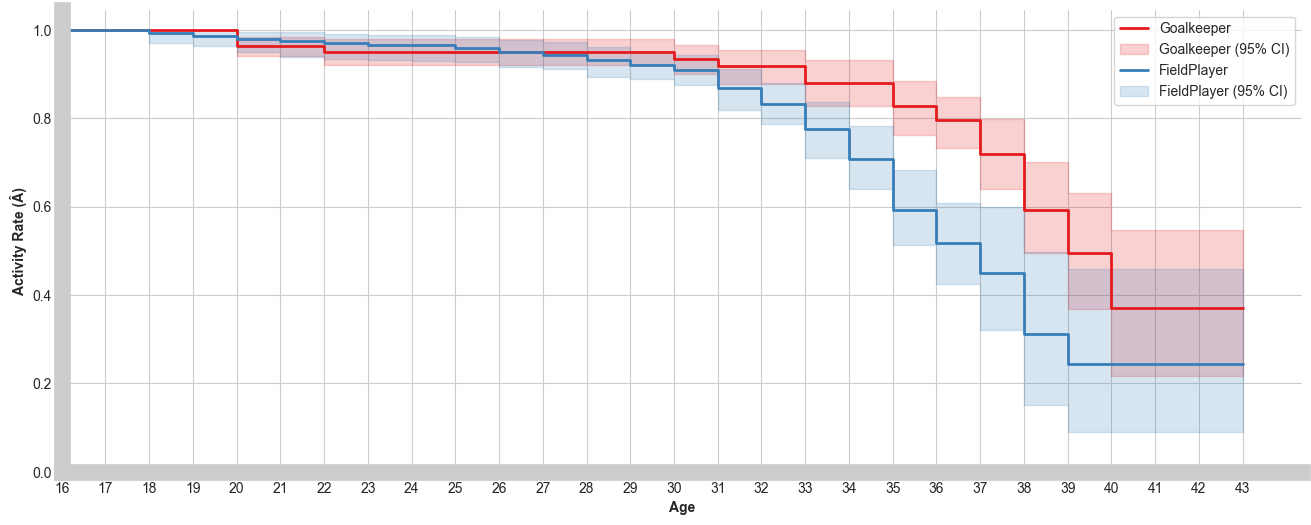

In [19]:
km_curves([position[k]["table"] for k in position], labels=[k for k in position], ci=True, color_palette="Set1")

In [20]:
pairwise_log_rank_test([position[k]["table"] for k in position], labels=[k for k in position], n_tests=n_tests)

### 1 Comparisons | Corrected alpha: 0.0071 ###
Goalkeeper vs FieldPlayer -> Stat: 7.357238673183522 - P-Value: 0.0066793292155507 - Rejected


### Including the Activity rate as a feature for players

In [21]:
"""
# Include a differential activity rate for low rate players
low_players = players[players.work_rate.isin(["Low/Low", "Low/Medium", "Medium/Low"])]
other_players = players[~players.work_rate.isin(["Low/Low", "Low/Medium", "Medium/Low"])]

low_players = low_players.merge(work_rate["Low"]["table"][["age", "A"]], on="age", how="left")
other_players = other_players.merge(professional_life_table[["age", "A"]], on="age", how="left")

players = pd.concat([low_players, other_players])
"""

# Include a differential activity rate for goalkeepers and field players
goalkeepers = players[players.position == "Goalkeeper"]
field = players[~(players.position == "Goalkeeper")]

goalkeepers = goalkeepers.merge(position["Goalkeeper"]["table"][["age", "A"]], on="age", how="left")
field = field.merge(position["FieldPlayer"]["table"][["age", "A"]], on="age", how="left")

players = pd.concat([goalkeepers, field]).sort_values("player_id")

In [25]:
players[["FIFA_long_name", "position", "age", "A"]]

,FIFA_long_name,position,age,A
9901,Roque Luis Santa Cruz Cantero,Attack,39,0.243045
325,Michael Ratajczak,Goalkeeper,38,0.592851
198,Patric Klandt,Goalkeeper,37,0.719891
1360,Mahir Sağlık,Attack,38,0.312487
358,Eldin Jakupović,Goalkeeper,36,0.795669
...,...,...,...,...
2377,Milan Robberechts,Attack,17,1.000000
3613,Noah Serwy,Attack,18,0.993443
1758,Robin Denuit,Defender,19,0.985742
8545,Axel Camblan,Midfield,18,0.993443
